# Analyzing rhythmicity to segment syllables/song

## Setup

In [1]:
pip install numpy scipy pyAudioAnalysis eyed3 pydub umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 39.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.14-py3-none-any.whl size=41264372 sha256=dd128574780b5f77029d17b04215089f483023e0f2ed1f2c80bdce1554d693a0
  Stored in directory: /root/.cache/pip/wheels/a7/54/73/fa830689c2440d2c81ff175c60e374930ad1607a8881e0f43f
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82807 sha256=4880cb89d6e959649171fb82609e1c78fb7db85afd8d49e3c9c5fc3b524e1cd1
  Stored in directory: /root/.cache/p

In [2]:
# Import Libraries
import numpy as np
import scipy
from scipy.io import wavfile
import numpy as np
import scipy
import pyAudioAnalysis as pyA
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import matplotlib.pyplot as plt

In [3]:
# Mount Drive to access files on google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Test that you can access relevant files -- and choose file for analysis
from scipy.io import wavfile
demoFile = '/content/drive/MyDrive/Rose_Bird/Demo_Wav_files/USA5207_45107.23982155_6_30_6_39_42.wav'
samplerate, data = wavfile.read(demoFile)

FS2 is  787.5000000000002


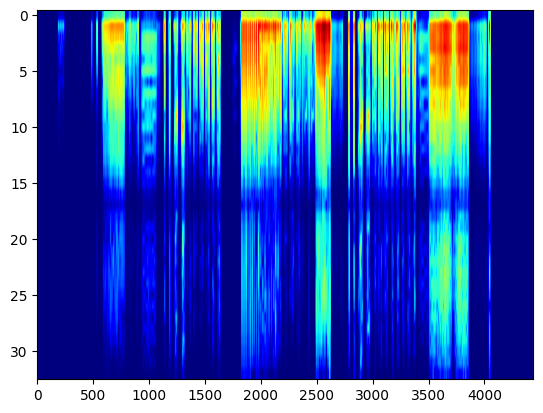

In [51]:
FS1 = samplerate
NFFT1 = 256
noverlap1 = 200
nperseg1 = 256

# Create Spectrogram + Rhythmicity
F1, T1, MAT1 = scipy.signal.spectrogram(data, FS1, nfft=NFFT1, noverlap=noverlap1, nperseg=nperseg1, scaling="density")

FS2 = 1/(T1[1] - T1[0])
NFFT2 = 64
noverlap2 = 60
nperseg2 = 64

print('FS2 is ',FS2)

F2, T2, MAT2 = scipy.signal.spectrogram(np.sum(MAT1,axis = 0), FS2, nfft=NFFT2, noverlap=noverlap2, nperseg=nperseg2, scaling="density")





plt.imshow(np.log(100+ MAT2),aspect = 'auto',cmap = 'jet')


(0.0, 100.0)

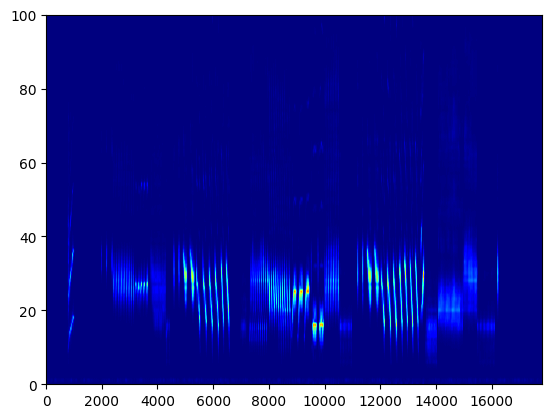

In [52]:
plt.imshow(np.log(10+ MAT1),aspect = 'auto',cmap = 'jet')
plt.ylim([0,100])

In [41]:
print(T1)
print(T2)
# Also interpolate F?

def interpolateMat(mat,oldTime,newTime):
  outputMat = np.zeros((mat.shape[0],len(newTime)))
  for row in range(mat.shape[0]):
    outputMat[row,:] = np.interp(newTime,oldTime,mat[row,:])

  return outputMat



def stackStretchMat(mat1,mat2,T1,T2,numPoints):

  if mat1.shape[0] != mat2.shape[0]:
    print('Rows do not match')

  # Take inner time for boundary issues
  startTime = max(T1[0],T2[0])
  endTime = min(T1[-1],T2[-1])

  # print(startTime)
  # print(endTime)

  numCols1 = mat1.shape[1]
  numCols2 = mat2.shape[1]

  desiredTimeSeries = np.linspace(startTime,endTime,numPoints)

  # Fix matrices
  stretchedMat1 = interpolateMat(mat1,T1,desiredTimeSeries)
  stretchedMat2 = interpolateMat(mat2,T2,desiredTimeSeries)


  return np.vstack((stretchedMat1,stretchedMat2)), desiredTimeSeries


[5.80498866e-03 7.21088435e-03 8.61678005e-03 ... 2.26182313e+01
 2.26196372e+01 2.26210431e+01]
[ 0.04498866  0.05061224  0.05623583 ... 22.55619048 22.56181406
 22.56743764]


Rows do not match
0.0011269134885315696


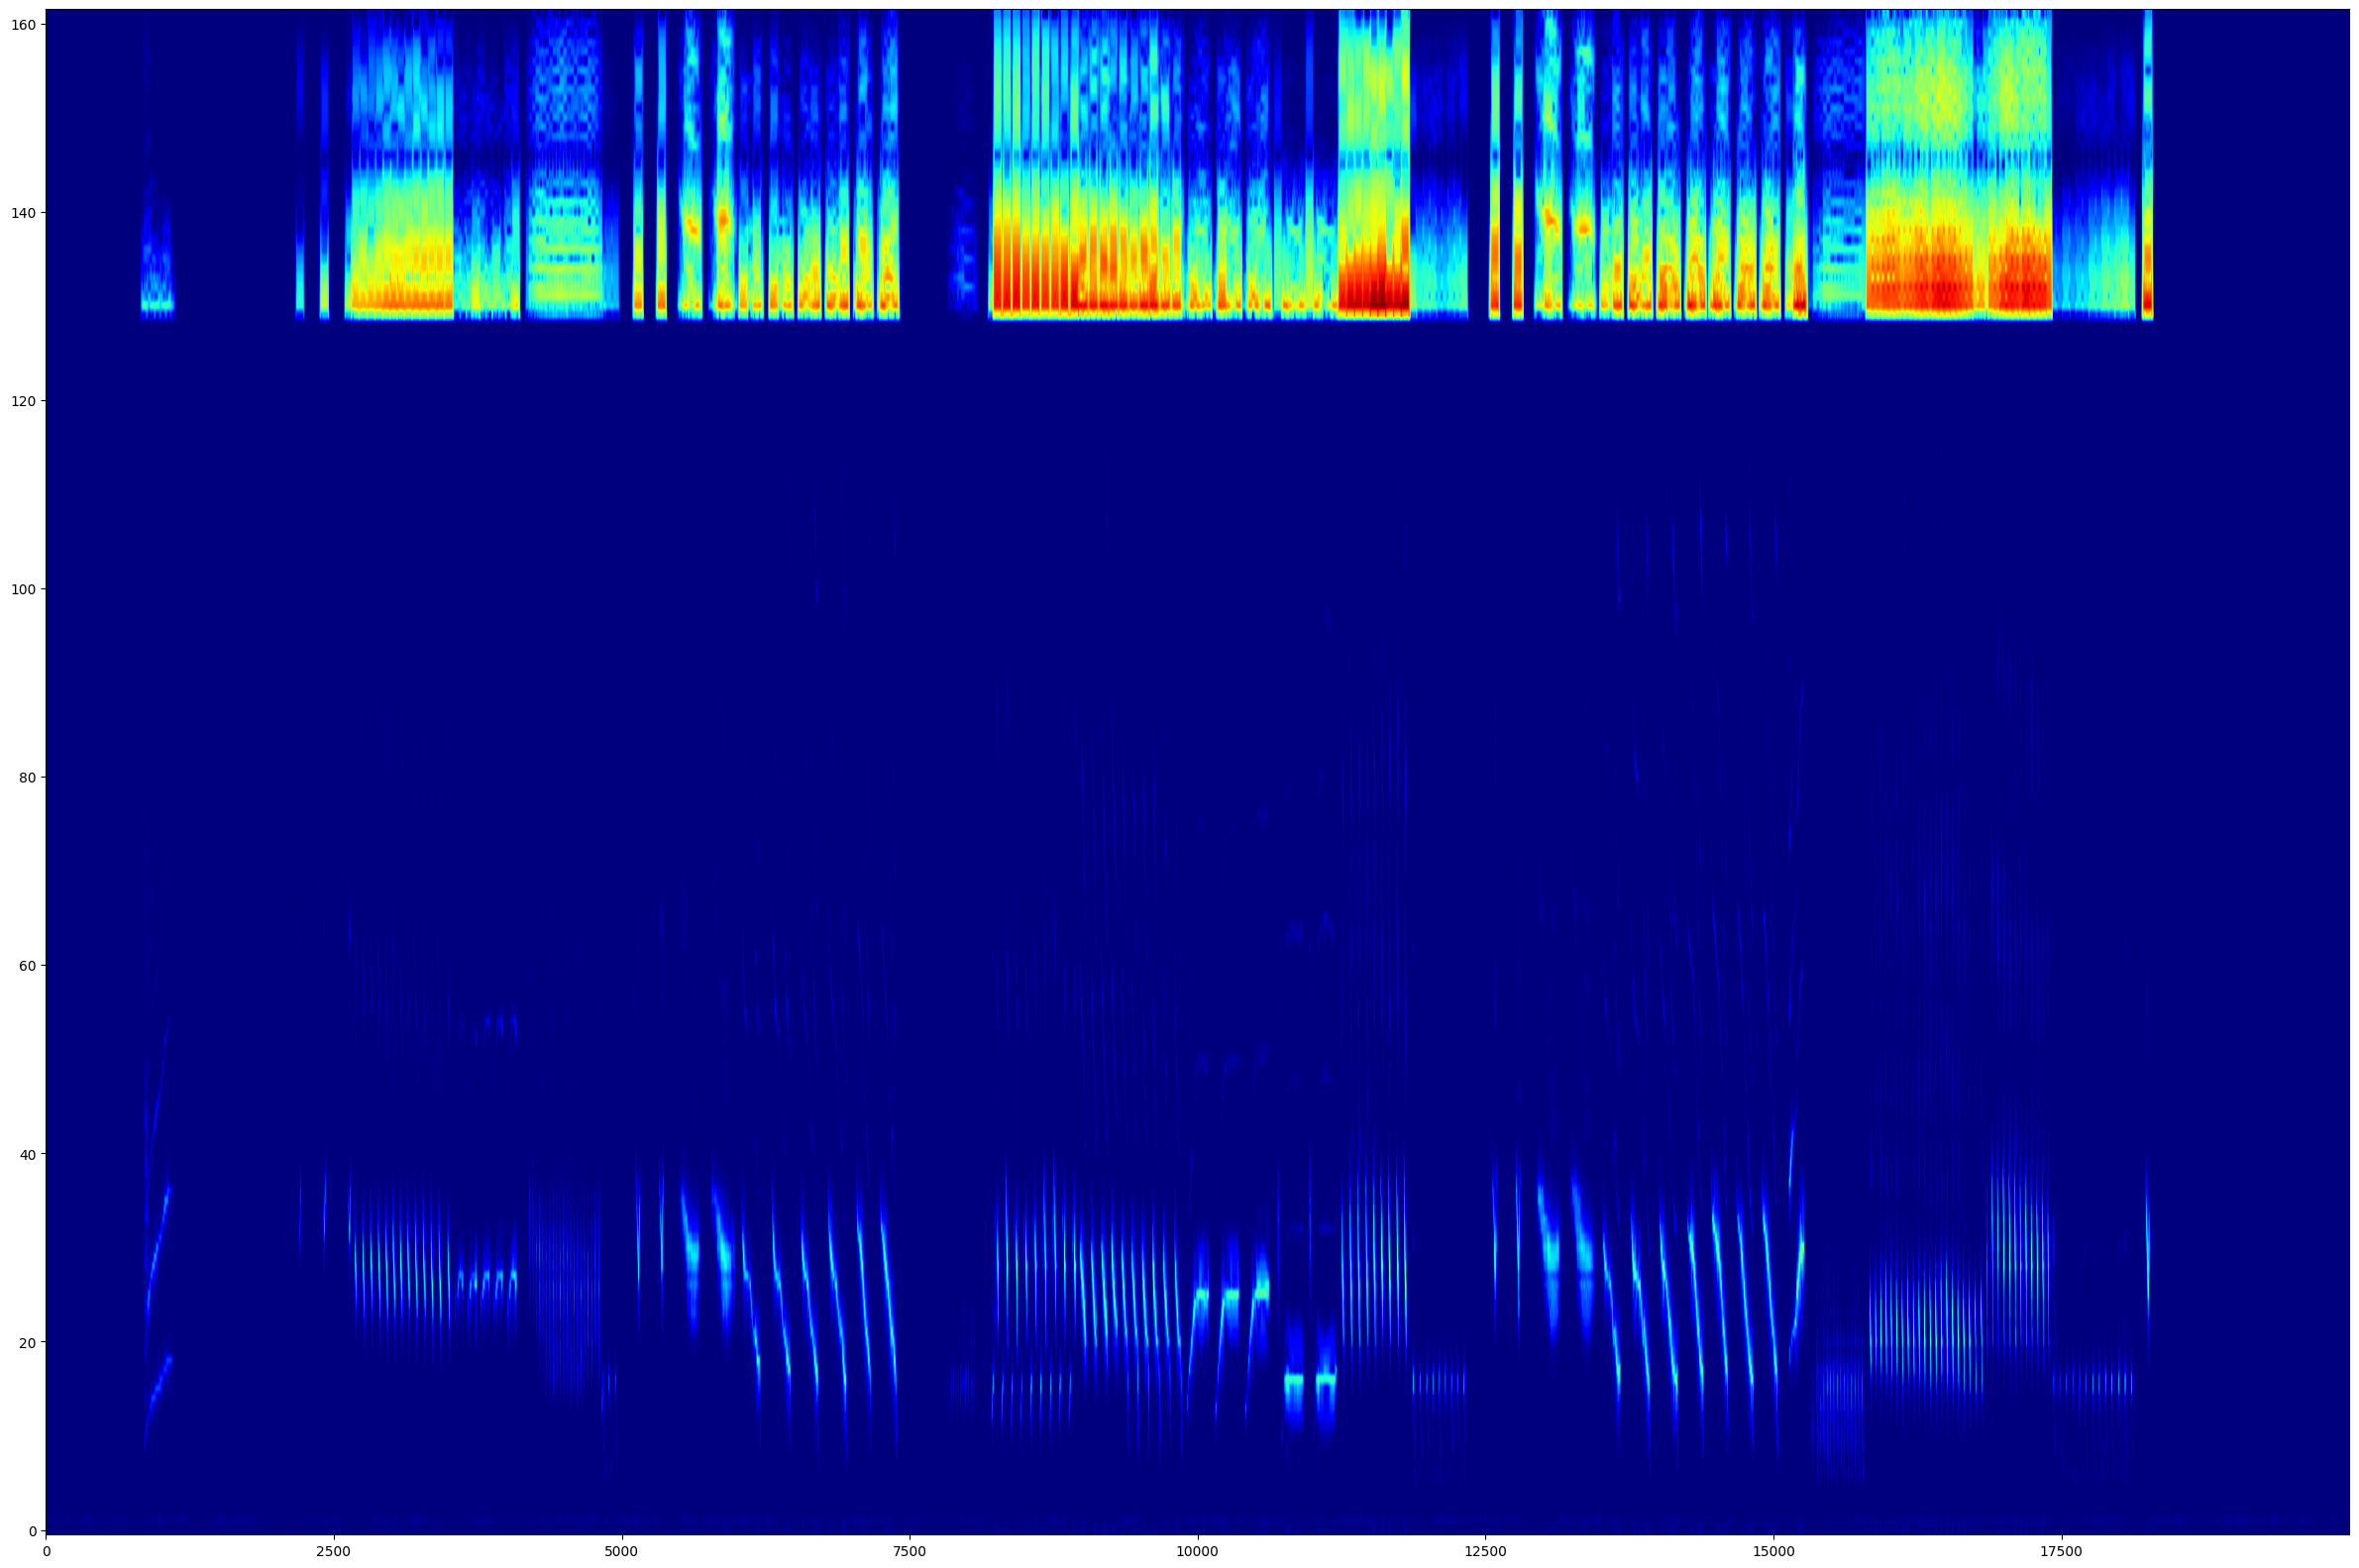

In [53]:
newMat, newT = stackStretchMat(MAT1,MAT2,T1,T2,20000)

print(newT[1] - newT[0])
newMatZ = scipy.stats.zscore(newMat)
plt.figure(figsize = (30,20))
plt.imshow(np.log(10+newMat),aspect = 'auto',origin = 'lower',cmap = 'jet')
#plt.imshow(newMatZ,aspect = 'auto',origin = 'lower',cmap = 'jet')

In [54]:
def get_matrix_slices(matrix, window_size, step_size):
    matrix_shape = matrix.shape
    num_slices = (matrix_shape[1] - window_size) // step_size + 1
    slices = np.zeros((matrix_shape[0], window_size, num_slices))
    start_times = np.zeros((num_slices))

    for i in range(num_slices):
        start = i * step_size
        end = start + window_size
        slices[:, :, i] = matrix[:, start:end]
        start_times[i] = start

    return slices,start_times

In [57]:
#import umap
A = np.log(10+newMat)
slices, start_times = get_matrix_slices(A,100, 1)

# Turn each slice into a 1D vector
original_shape = slices.shape
flattened_matrix = slices.reshape(original_shape[0] * original_shape[1], original_shape[2]).T

# Load the umap library, and transform the data
#import umap
fit = umap.UMAP()
spec_emb = fit.fit_transform(flattened_matrix)

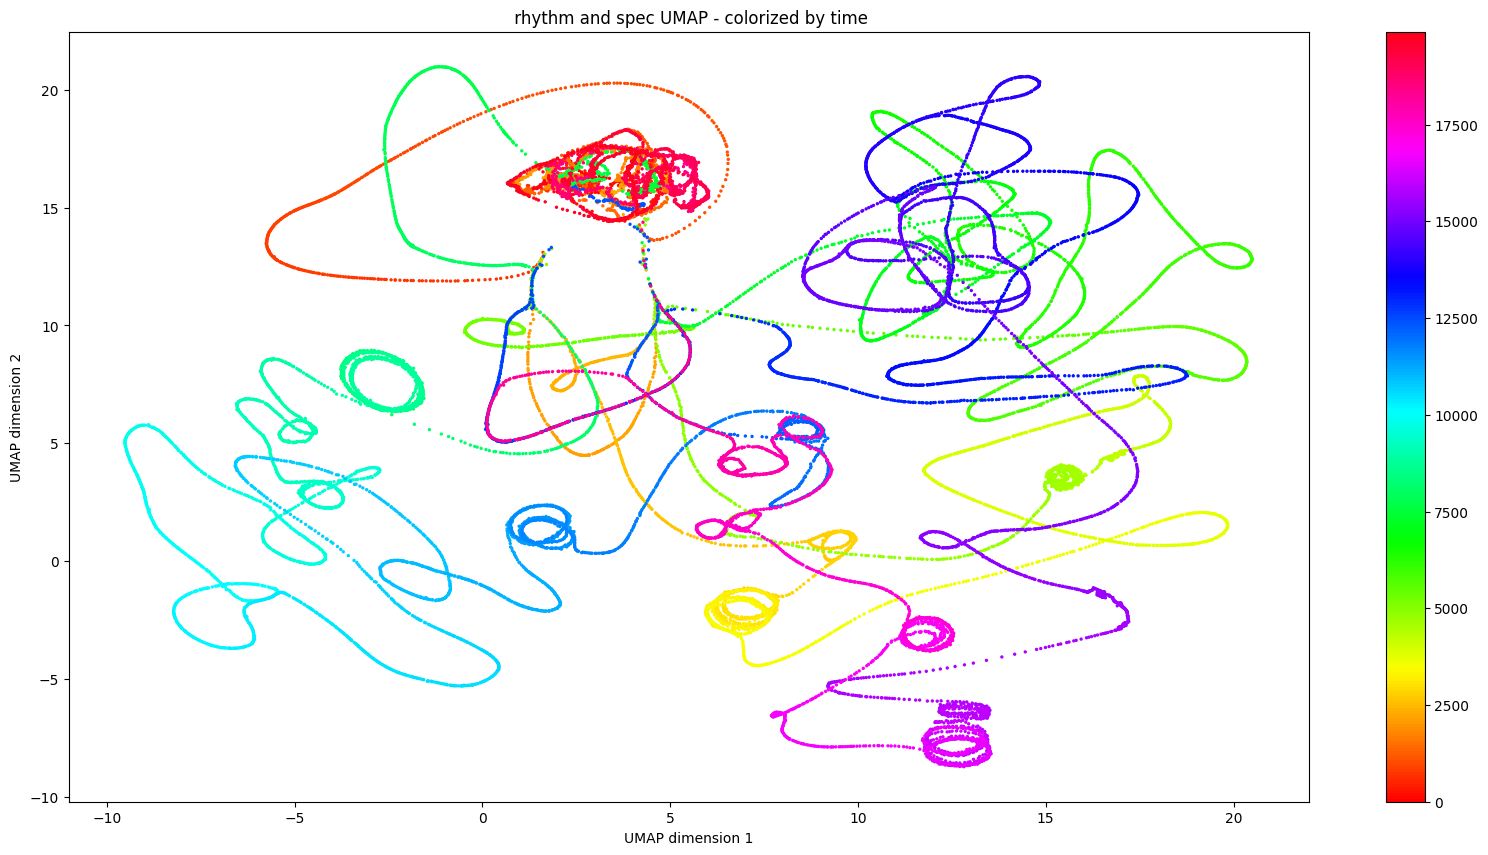

In [58]:
plt.figure(figsize=(20,10))
plt.scatter(spec_emb[:,0],spec_emb[:,1],s = 2,cmap='hsv',c = np.arange(spec_emb.shape[0]))
plt.title(' rhythm and spec UMAP - colorized by time')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.colorbar()
plt.show()

In [ ]:
Test = compute_cepstrum(np.abs(np.random.rand(100)))
print(Test)

None


float64


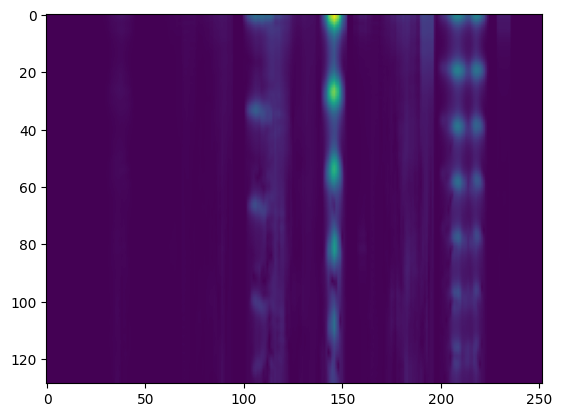

In [ ]:
# newCep = rythmicity2.copy()
cepImg = None
for i in range(0,newCep.shape[1]):
  #newCep[:,i] = compute_cepstrum(np.abs(rythmicity2[:,i]))
  #newCep[:,i] = np.abs(ifft(np.log(np.absolute(rythmicity2[:,i]))))
  cep = np.abs(np.fft.rfft(rythmicity2[:,i]))
  #print(rythmicity2[i,:])


  try:
    cepImg = np.vstack((cepImg,cep))
  except:
    cepImg = cep

print(cepImg.dtype)
plt.imshow(cepImg.astype(int).T,aspect = 'auto')

In [ ]:
# GPT
def interpolate_and_stack_arrays(arr1, arr2, target_num_columns):
    num_rows = arr1.shape[0]

    # Interpolate arr1 to the target number of columns
    x_old = np.linspace(0, 1, arr1.shape[1])
    x_new = np.linspace(0, 1, target_num_columns)
    interpolated_arr1 = np.zeros((num_rows, target_num_columns))
    for i in range(num_rows):
        interpolated_arr1[i, :] = np.interp(x_new, x_old, arr1[i, :])

    # Interpolate arr2 to the target number of columns
    x_old = np.linspace(0, 1, arr2.shape[1])
    x_new = np.linspace(0, 1, target_num_columns)
    interpolated_arr2 = np.zeros((num_rows, target_num_columns))
    for i in range(num_rows):
        interpolated_arr2[i, :] = np.interp(x_new, x_old, arr2[i, :])

    # Stack the interpolated arrays vertically
    stacked_array = np.vstack((interpolated_arr1, interpolated_arr2))

    return stacked_array

In [ ]:
print(spectrum.shape)
print(rythmicity2.shape)

(257, 83116)
(257, 252)


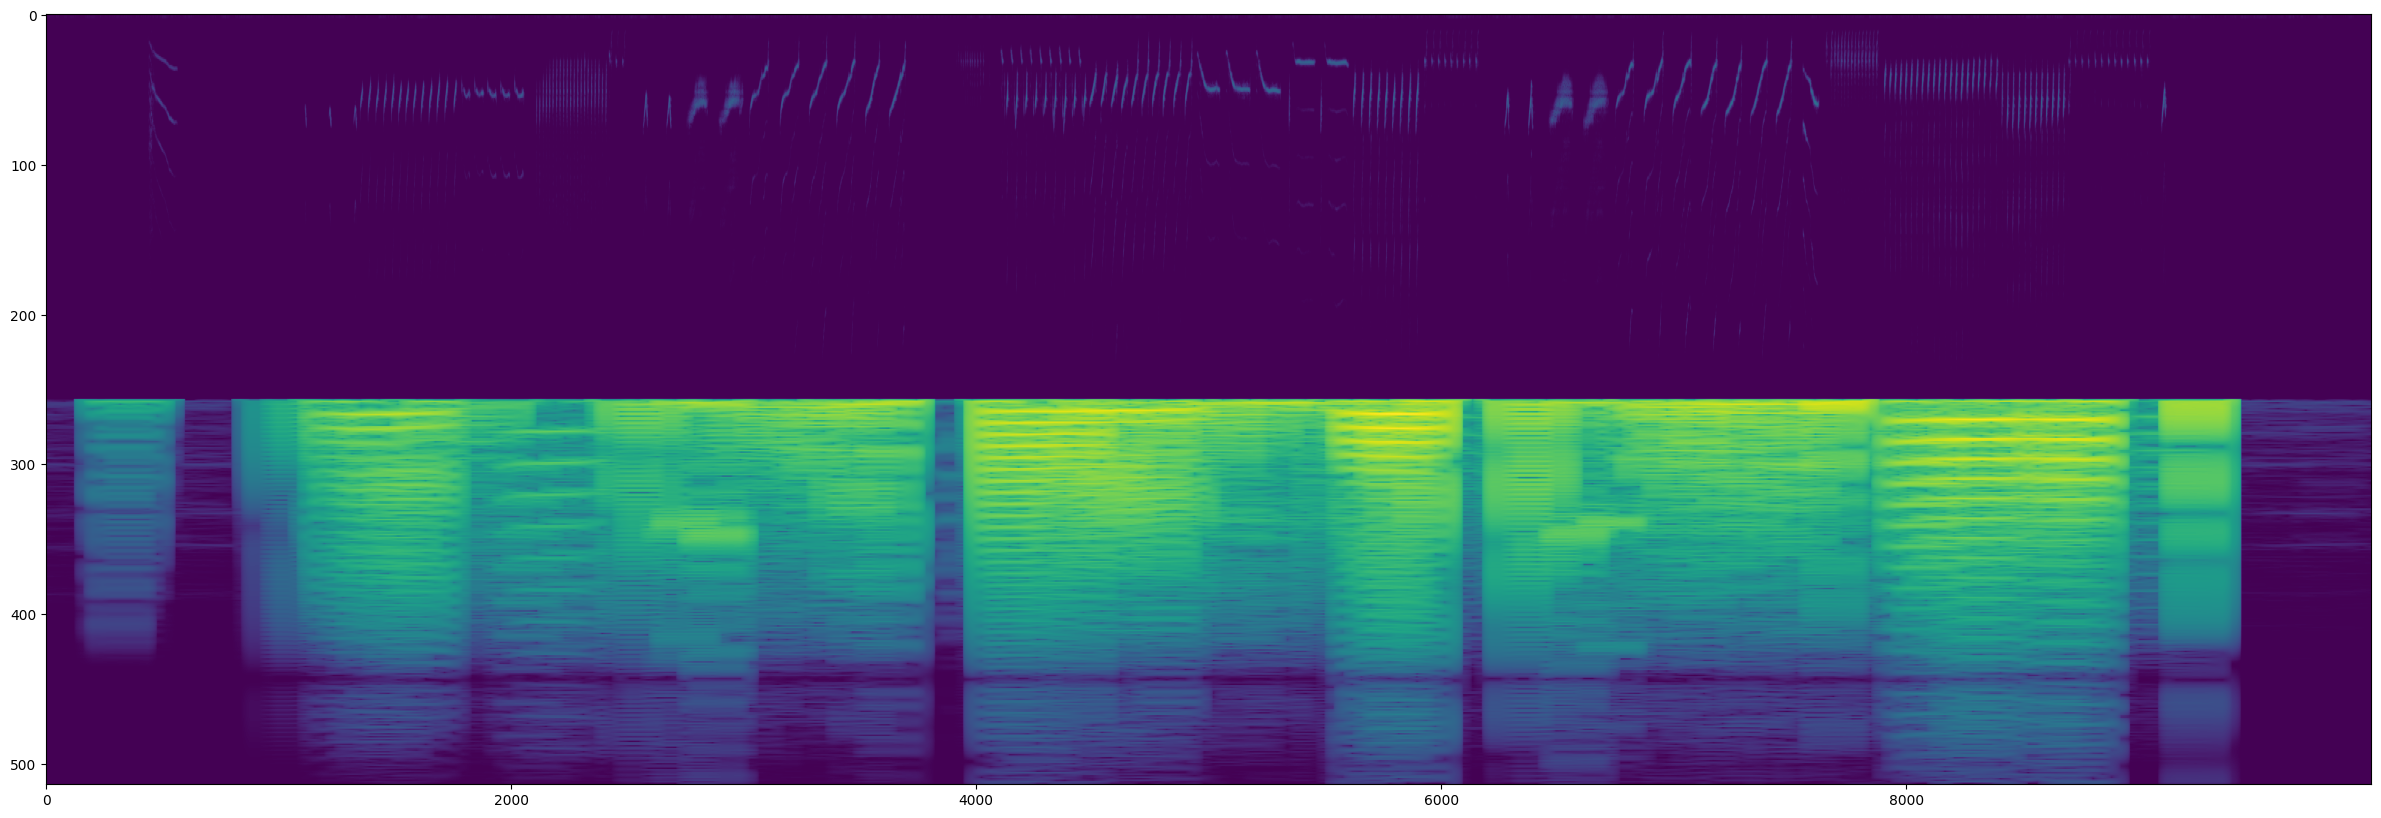

In [ ]:
newArr = interpolate_and_stack_arrays(spectrum,rythmicity2,10000)

plt.figure(figsize=(30,10))
plt.imshow(np.log(5+newArr),aspect = 'auto')